In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [2]:
dataset_path = "Raw Data/Fruit And Vegetable Diseases Dataset"
image_size = (224, 224)  # Resize images to 224x224 pixels
batch_size = 16
epochs = 20

In [3]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
            filenames.append(img_path)
    return images, labels, filenames

In [4]:
# Initialize lists for images, labels, and filenames
all_images = []
all_labels = []
all_filenames = []

# Load images from each directory
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if "Healthy" in category:
        label = 0  # Label for healthy images
    else:
        label = 1  # Label for rotten images
    images, labels, filenames = load_images_from_folder(category_path, label)
    all_images.extend(images)
    all_labels.extend(labels)
    all_filenames.extend(filenames)

# Convert to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(f"Total images loaded: {len(all_images)}")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Total images loaded: 29291


In [5]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp, train_filenames, temp_filenames = train_test_split(
    all_images, all_labels, all_filenames, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, val_filenames, test_filenames = train_test_split(
    X_temp, y_temp, temp_filenames, test_size=0.5, random_state=42)

# Print dataset shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (23432, 224, 224, 3) (23432,)
Validation set shape: (2929, 224, 224, 3) (2929,)
Test set shape: (2930, 224, 224, 3) (2930,)


In [6]:
# Count the number of samples in each class
def count_class_samples(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

In [7]:
train_counts = count_class_samples(y_train)
val_counts = count_class_samples(y_val)
test_counts = count_class_samples(y_test)

print(f"Training set class distribution: {train_counts}")
print(f"Validation set class distribution: {val_counts}")
print(f"Test set class distribution: {test_counts}")

Training set class distribution: {0: 11007, 1: 12425}
Validation set class distribution: {0: 1418, 1: 1511}
Test set class distribution: {0: 1362, 1: 1568}


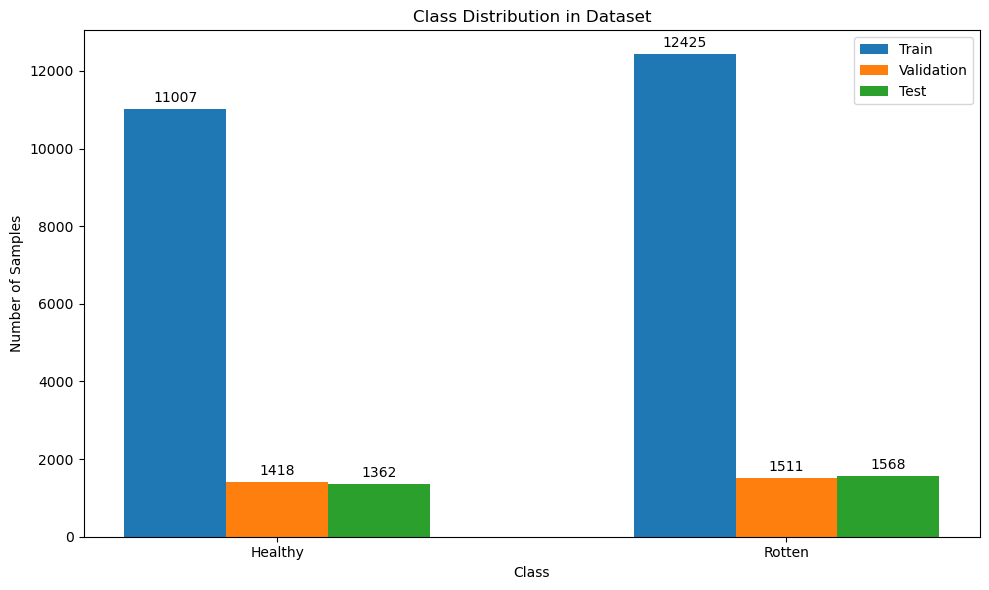

In [8]:
# Visualize the distribution
def plot_class_distribution(train_counts, val_counts, test_counts):
    classes = ['Healthy', 'Rotten']
    train_values = [train_counts.get(0, 0), train_counts.get(1, 0)]
    val_values = [val_counts.get(0, 0), val_counts.get(1, 0)]
    test_values = [test_counts.get(0, 0), test_counts.get(1, 0)]
    
    x = np.arange(len(classes))  # label locations
    width = 0.2  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    
    rects1 = ax.bar(x - width, train_values, width, label='Train')
    rects2 = ax.bar(x, val_values, width, label='Validation')
    rects3 = ax.bar(x + width, test_values, width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Class Distribution in Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()

plot_class_distribution(train_counts, val_counts, test_counts)

In [9]:
# Convert lists to sets
train_filenames_set = set(train_filenames)
val_filenames_set = set(val_filenames)
test_filenames_set = set(test_filenames)

In [10]:
# Check for overlaps
overlap_train_val = train_filenames_set.intersection(val_filenames_set)
overlap_train_test = train_filenames_set.intersection(test_filenames_set)
overlap_val_test = val_filenames_set.intersection(test_filenames_set)

print(f"Overlap between train and val sets: {len(overlap_train_val)}")
print(f"Overlap between train and test sets: {len(overlap_train_test)}")
print(f"Overlap between val and test sets: {len(overlap_val_test)}")

Overlap between train and val sets: 0
Overlap between train and test sets: 0
Overlap between val and test sets: 0


In [11]:
def convert_to_tf_dataset(images, labels, batch_size, repeat=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    if repeat:
        dataset = dataset.repeat()  # Repeat the dataset for the required number of epochs
    return dataset

# Convert datasets with repeat set to True
train_dataset = convert_to_tf_dataset(X_train, y_train, batch_size, repeat=True)
val_dataset = convert_to_tf_dataset(X_val, y_val, batch_size, repeat=False)
test_dataset = convert_to_tf_dataset(X_test, y_test, batch_size, repeat=False)

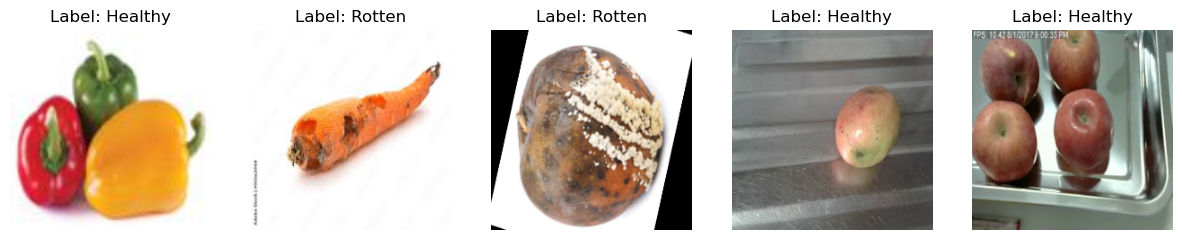

In [12]:
def visualize_samples(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Label: {'Healthy' if labels[i] == 0 else 'Rotten'}")
        axes[i].axis('off')
    plt.show()

visualize_samples(X_train, y_train)

In [13]:
# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create train, validation, and test generators
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=batch_size)

In [15]:
def build_model(input_shape):
    model = Sequential([
        Input(input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (healthy vs rotten)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (image_size[0], image_size[1], 3)
model = build_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,505 (169.36 MB)

 Trainable params: 44,397,057 (169.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size
)

Epoch 1/20


/Users/jin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 802/1464 ━━━━━━━━━━━━━━━━━━━━ 3:34 324ms/step - accuracy: 0.6310 - loss: 1.9541

KeyboardInterrupt: 

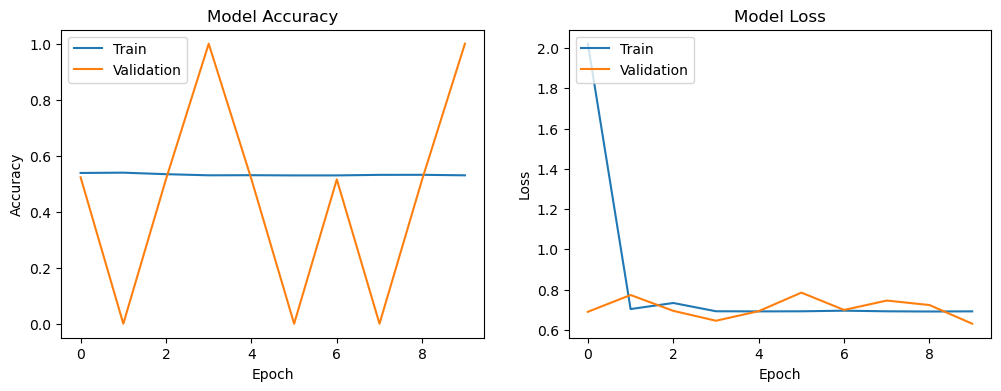

In [12]:
# Plot Training Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [42]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5419 - loss: 0.6899
Test Accuracy: 53.52%
